<a href="https://colab.research.google.com/github/syedmuneeb321/LangGraph-Explorations/blob/main/Getting_Started_With_LangGraph/agent_with_human_in_the_loop_part_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
%%capture --no-stderr
%pip install -U langgraph langsmith langchain_google_genai tavily-python langchain_community

In [ ]:
import os
from google.colab import userdata

os.environ["LANGCHAIN_API_KEY"] = userdata.get('LANGCHAIN_API_KEY')
os.environ["LANGCHAIN_TRACING_V2"] = "true"
os.environ["LANGCHAIN_PROJECT"] = "quickstart"
os.environ["TAVILY_API_KEY"] = userdata.get("TAVILY_API_KEY")

gemini_api_key = userdata.get('GOOGLE_API_KEY')

In [ ]:
from langchain_google_genai import ChatGoogleGenerativeAI

llm = ChatGoogleGenerativeAI(
    model="gemini-1.5-flash",
    max_retries=2,
    api_key=gemini_api_key
)


In [ ]:
from langchain_community.tools import TavilySearchResults
tool = TavilySearchResults(max_results=2)
llm_with_tool = llm.bind_tools([tool])

In [ ]:
from typing import Annotated
from typing_extensions import TypedDict
from langgraph.graph.message import add_messages
# make a state
class State(TypedDict):
  messages: Annotated[list,add_messages ]

In [ ]:
def chat_bot(state:State)->State:
  response = llm_with_tool.invoke(state["messages"])
  return {"messages":[response]}

In [ ]:
from langgraph.graph import StateGraph,START
from langgraph.prebuilt import ToolNode,tools_condition
from langgraph.checkpoint.memory import MemorySaver

graph_builder = StateGraph(State)

graph_builder.add_node("chat_bot",chat_bot)
graph_builder.add_node("tools",ToolNode(tools=[tool]))

# logic

graph_builder.add_edge(START,"chat_bot")
graph_builder.add_conditional_edges("chat_bot",tools_condition)
graph_builder.add_edge("tools","chat_bot")


memory = MemorySaver()

app = graph_builder.compile(checkpointer=memory,interrupt_before=["tools"])



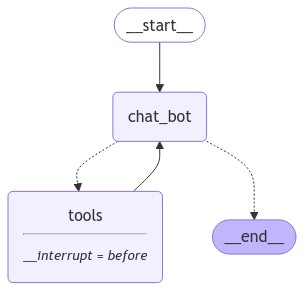

In [ ]:
from IPython.display import Image, display

try:
    display(Image(app.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

In [ ]:
# input = {"messages":[("user","what is langgraph")]}
config = {"configurable":{"thread_id":"1"}}

In [ ]:
events = app.stream({"messages":[("user","I'm learning LangGraph. Could you do some research on it for me?")]},config,stream_mode="values")
# events = graph.stream({"messages": [("user", user_input)]}, config)
for event in events:
    if "messages" in event:
        event["messages"][-1].pretty_print()

================================ Human Message =================================

I'm learning LangGraph. Could you do some research on it for me?
================================== Ai Message ==================================
Tool Calls:
  tavily_search_results_json (53e9b316-05eb-4708-85db-f3100c362394)
 Call ID: 53e9b316-05eb-4708-85db-f3100c362394
  Args:
    query: LangGraph


In [ ]:
snapshot = app.get_state(config)
existing_message = snapshot.values["messages"][-1]
existing_message.pretty_print()



================================== Ai Message ==================================
Tool Calls:
  tavily_search_results_json (53e9b316-05eb-4708-85db-f3100c362394)
 Call ID: 53e9b316-05eb-4708-85db-f3100c362394
  Args:
    query: LangGraph


In [ ]:
snapshot.next

In [ ]:
from langchain_core.messages import AIMessage, ToolMessage
answer = "LangGraph is a library for building stateful, multi-actor applications with LLMs."
new_messages = [
    ToolMessage(
        content = answer,
        tool_call_id = existing_message.tool_calls[0]['id'],

    ),
    AIMessage(
        content = answer
    ),
]

In [ ]:
app.update_state(config,{"messages":new_messages})
for messages in app.get_state(config).values["messages"]:
  messages.pretty_print()



================================ Human Message =================================

I'm learning LangGraph. Could you do some research on it for me?
================================== Ai Message ==================================
Tool Calls:
  tavily_search_results_json (53e9b316-05eb-4708-85db-f3100c362394)
 Call ID: 53e9b316-05eb-4708-85db-f3100c362394
  Args:
    query: LangGraph
================================= Tool Message =================================

LangGraph is a library for building stateful, multi-actor applications with LLMs.
================================== Ai Message ==================================

LangGraph is a library for building stateful, multi-actor applications with LLMs.


In [ ]:
snapshot = app.get_state(config)
snapshot.next

()

In [ ]:
user_input = "I'm learning LangGraph. Could you do some research on it for me?"
config = {"configurable":{"thread_id":"21"}}
events = app.stream({"messages":[("user",user_input)]},config,stream_mode="values")
for event in events:
  if "messages" in event:
    event["messages"][-1].pretty_print()

================================ Human Message =================================

I'm learning LangGraph. Could you do some research on it for me?
================================== Ai Message ==================================
Tool Calls:
  tavily_search_results_json (a225a891-7997-43c7-ba88-f7bddc63da5d)
 Call ID: a225a891-7997-43c7-ba88-f7bddc63da5d
  Args:
    query: LangGraph


In [ ]:
from langchain_core.messages import AIMessage
snapshot2 = app.get_state(config)
existing_message2 = snapshot2.values['messages'][-1]
existing_message2.pretty_print()

================================== Ai Message ==================================
Tool Calls:
  tavily_search_results_json (a225a891-7997-43c7-ba88-f7bddc63da5d)
 Call ID: a225a891-7997-43c7-ba88-f7bddc63da5d
  Args:
    query: LangGraph


In [ ]:
print("print original id")
print(existing_message2.id)

print original id
run-5c8b0c63-a99e-443c-a0ec-9fcec01223b0-0


In [ ]:
new_tool_call = existing_message2.tool_calls[0].copy()
print("print new tool call")
print(new_tool_call)

print new tool call
{'name': 'tavily_search_results_json', 'args': {'query': 'LangGraph'}, 'id': 'a225a891-7997-43c7-ba88-f7bddc63da5d', 'type': 'tool_call'}


In [ ]:
new_tool_call['args']['query'] = "LangGraph human-in-the-loop workflow"
new_tool_call

{'name': 'tavily_search_results_json',
 'args': {'query': 'LangGraph human-in-the-loop workflow'},
 'id': 'a225a891-7997-43c7-ba88-f7bddc63da5d',
 'type': 'tool_call'}

In [ ]:
new_ai_message = AIMessage(
    content = existing_message2.content,
    tool_calls = [new_tool_call],
    id=existing_message.id,

)

new_ai_message


AIMessage(content='', additional_kwargs={}, response_metadata={}, id='run-b02c5014-ce49-40e5-a757-5d5b36d911a9-0', tool_calls=[{'name': 'tavily_search_results_json', 'args': {'query': 'LangGraph human-in-the-loop workflow'}, 'id': 'a225a891-7997-43c7-ba88-f7bddc63da5d', 'type': 'tool_call'}])

In [ ]:
app.update_state(config,{"messages":[new_ai_message]})
app.get_state(config).values["messages"][-1].pretty_print()

================================== Ai Message ==================================
Tool Calls:
  tavily_search_results_json (a225a891-7997-43c7-ba88-f7bddc63da5d)
 Call ID: a225a891-7997-43c7-ba88-f7bddc63da5d
  Args:
    query: LangGraph human-in-the-loop workflow


In [ ]:
events = app.stream(None,config,stream_mode="values")
for event in events:
  if "messages" in event:
    event["messages"][-1].pretty_print()

================================== Ai Message ==================================
Tool Calls:
  tavily_search_results_json (a225a891-7997-43c7-ba88-f7bddc63da5d)
 Call ID: a225a891-7997-43c7-ba88-f7bddc63da5d
  Args:
    query: LangGraph human-in-the-loop workflow
================================= Tool Message =================================
Name: tavily_search_results_json

[{"url": "https://www.youtube.com/watch?v=9BPCV5TYPmg", "content": "In this video, I'll show you how to handle persistence with LangGraph, enabling a unique Human-in-the-Loop workflow. This approach allows a human to grant an"}, {"url": "https://github.com/langchain-ai/langgraph", "content": "Additionally, LangGraph includes built-in persistence, enabling advanced human-in-the-loop and memory features. LangGraph is inspired by Pregel and Apache Beam. The public interface draws inspiration from NetworkX. LangGraph is built by LangChain Inc, the creators of LangChain, but can be used without LangChain. LangGraph Pla

In [ ]:
app.get_state(config).values["messages"][-1].pretty_print()

================================== Ai Message ==================================

LangGraph is a graph-based framework for building and deploying large language models (LLMs). It is inspired by Pregel and Apache Beam, and its public interface draws inspiration from NetworkX. LangGraph is built by LangChain Inc, the creators of LangChain, but can be used without LangChain. LangGraph Platform is a cloud-based platform that provides a user-friendly interface for building and deploying LangGraph applications. It allows users to create and manage graphs, define nodes and edges, and run queries. LangGraph is a powerful tool for building complex LLM applications. It provides a flexible and scalable framework for managing and querying large datasets of text and code.


In [ ]:
for event in app.stream({"messages":[("user","what is weather of lahore")]},config,stream_mode="values"):
  for message in event["messages"]:
    message.pretty_print()

================================ Human Message =================================

what is weather of lahore
================================ Human Message =================================

what is weather of lahore
================================== Ai Message ==================================
Tool Calls:
  tavily_search_results_json (b548da94-9575-4dab-be4a-100e87caeea9)
 Call ID: b548da94-9575-4dab-be4a-100e87caeea9
  Args:
    query: weather of lahore


In [ ]:
snap_shot = app.get_state(config)
print(snap_shot.values)
for value in snap_shot.values["messages"]:
  value.pretty_print()

{'messages': [HumanMessage(content='what is weather of lahore', additional_kwargs={}, response_metadata={}, id='d51f69e8-b305-4903-830e-7deda3ee8e61'), AIMessage(content='', additional_kwargs={'function_call': {'name': 'tavily_search_results_json', 'arguments': '{"query": "weather of lahore"}'}}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'safety_ratings': [{'category': 'HARM_CATEGORY_DANGEROUS_CONTENT', 'probability': 'NEGLIGIBLE', 'blocked': False}, {'category': 'HARM_CATEGORY_HARASSMENT', 'probability': 'NEGLIGIBLE', 'blocked': False}, {'category': 'HARM_CATEGORY_HATE_SPEECH', 'probability': 'NEGLIGIBLE', 'blocked': False}, {'category': 'HARM_CATEGORY_SEXUALLY_EXPLICIT', 'probability': 'NEGLIGIBLE', 'blocked': False}]}, id='run-a8d8ec07-7c27-4513-a0d9-f883142e5b25-0', tool_calls=[{'name': 'tavily_search_results_json', 'args': {'query': 'weather of lahore'}, 'id': 'b548da94-9575-4dab-be4a-100e87caeea9', 'type': 'tool_call

In [ ]:
snap_shot.next

('tools',)

In [ ]:
snap_shot.values["messages"][-1].tool_calls[0]['id']

'09cedf53-3f61-492b-acc9-3b9f14334149'

In [ ]:
from langchain_core.messages import HumanMessage, ToolMessage

tool_message = ToolMessage(
    content="Lahore, Punjab. 85°F.",
    tool_call_id=snap_shot.values["messages"][-1].tool_calls[0]['id'],
    id = snap_shot.values["messages"][-1].id

)
tool_message

ToolMessage(content='Lahore, Punjab. 85°F.', id='run-e6212594-828d-4ccc-b740-ae638dfedb3e-0', tool_call_id='09cedf53-3f61-492b-acc9-3b9f14334149')

In [ ]:
app.update_state(config,{"messages":[tool_message]})
snap_shot = app.get_state(config)
snap_shot.next

for value in snap_shot.values["messages"]:
  value.pretty_print()

================================ Human Message =================================

what is weather of lahore
================================== Ai Message ==================================
Tool Calls:
  tavily_search_results_json (b548da94-9575-4dab-be4a-100e87caeea9)
 Call ID: b548da94-9575-4dab-be4a-100e87caeea9
  Args:
    query: weather of lahore
================================= Tool Message =================================
Name: tavily_search_results_json

[{"url": "https://www.weatherapi.com/", "content": "{'location': {'name': 'Lahore', 'region': 'Punjab', 'country': 'Pakistan', 'lat': 31.5497, 'lon': 74.3436, 'tz_id': 'Asia/Karachi', 'localtime_epoch': 1730816622, 'localtime': '2024-11-05 19:23'}, 'current': {'last_updated_epoch': 1730816100, 'last_updated': '2024-11-05 19:15', 'temp_c': 26.2, 'temp_f': 79.2, 'is_day': 0, 'condition': {'text': 'Overcast', 'icon': '//cdn.weatherapi.com/weather/64x64/night/122.png', 'code': 1009}, 'wind_mph': 4.9, 'wind_kph': 7.9, 'wind_degree'

In [ ]:
for event in app.stream(None,config,stream_mode="values"):
  print(event)

{'messages': [HumanMessage(content='what is weather of lahore', additional_kwargs={}, response_metadata={}, id='d51f69e8-b305-4903-830e-7deda3ee8e61'), AIMessage(content='', additional_kwargs={'function_call': {'name': 'tavily_search_results_json', 'arguments': '{"query": "weather of lahore"}'}}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'safety_ratings': [{'category': 'HARM_CATEGORY_DANGEROUS_CONTENT', 'probability': 'NEGLIGIBLE', 'blocked': False}, {'category': 'HARM_CATEGORY_HARASSMENT', 'probability': 'NEGLIGIBLE', 'blocked': False}, {'category': 'HARM_CATEGORY_HATE_SPEECH', 'probability': 'NEGLIGIBLE', 'blocked': False}, {'category': 'HARM_CATEGORY_SEXUALLY_EXPLICIT', 'probability': 'NEGLIGIBLE', 'blocked': False}]}, id='run-a8d8ec07-7c27-4513-a0d9-f883142e5b25-0', tool_calls=[{'name': 'tavily_search_results_json', 'args': {'query': 'weather of lahore'}, 'id': 'b548da94-9575-4dab-be4a-100e87caeea9', 'type': 'tool_call

In [ ]:
snap_shot = app.get_state(config)
for value in snap_shot.values["messages"]:
  value.pretty_print()
snap_shot.next